In [2]:
from google.colab import drive

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!cp '/content/drive/MyDrive/interview/accident.zip' /content/

In [5]:
!unzip accident.zip -d ./dataset

Archive:  accident.zip
  inflating: ./dataset/US_Accidents_March23.csv  


All the cells above are used for impoting the dataset from my drive to colab and then copying it into my local directory inside colab and then unzipping to use for making the model.

In [6]:
import pandas as pd

FILE_PATH = "/content/dataset/US_Accidents_March23.csv"

df = pd.read_csv(
    FILE_PATH,
    low_memory=True
)


print(df.shape)



(7728394, 46)


In [7]:
df.shape

(7728394, 46)

Dropped non-informative identifiers.These columns are doesnt have features that influence the severity rate.

In [8]:
DROP_COLS = [
    "ID",
    "Description",
    "Street",
    "Number",
    "Zipcode",
    "Country",
    "Airport_Code"
]

existing_cols = [c for c in DROP_COLS if c in df.columns]
missing_cols = [c for c in DROP_COLS if c not in df.columns]

print("Dropping:", existing_cols)
print("Not found (skipped):", missing_cols)

df.drop(columns=existing_cols, inplace=True)
print(df.shape)


Dropping: ['ID', 'Description', 'Street', 'Zipcode', 'Country', 'Airport_Code']
Not found (skipped): ['Number']
(7728394, 40)


In [9]:
print(df.shape)
print(df.columns.tolist())


(7728394, 40)
['Source', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)', 'City', 'County', 'State', 'Timezone', 'Weather_Timestamp', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight']


It converts the Start_Time and End_Time columns from strings into datetime objects.

In [10]:
df["Start_Time"] = pd.to_datetime(df["Start_Time"], errors="coerce")
df["End_Time"] = pd.to_datetime(df["End_Time"], errors="coerce")


In [11]:
df["Accident_Duration_Min"] = (
    df["End_Time"] - df["Start_Time"]
).dt.total_seconds() / 60


Negative or invalid accident durations were clipped and imputed to maintain physical plausibility

In [12]:
df["Accident_Duration_Min"] = df["Accident_Duration_Min"].clip(lower=0)
df["Accident_Duration_Min"] = df["Accident_Duration_Min"].fillna(
    df["Accident_Duration_Min"].median()
)


In [13]:
df["Accident_Duration_Min"].describe()

,Accident_Duration_Min
count,7.728394e+06
mean,3.918587e+02
std,1.259140e+04
min,1.216667e+00
25%,3.368750e+01
50%,6.271667e+01
75%,1.165000e+02
max,2.812939e+06


Extreme duration values caused by reporting anomalies were capped at the 99th percentile to reduce skew while preserving signal. Above Max ≈ 2.8 million minutes (~5 years).

In [14]:
upper_cap = df["Accident_Duration_Min"].quantile(0.99)

df["Accident_Duration_Min"] = df["Accident_Duration_Min"].clip(
    lower=0,
    upper=upper_cap
)


In [15]:
df["Accident_Duration_Min"].describe()

,Accident_Duration_Min
count,7.728394e+06
mean,1.031913e+02
std,1.175387e+02
min,1.216667e+00
25%,3.368750e+01
50%,6.271667e+01
75%,1.165000e+02
max,7.466000e+02


In [16]:
df.drop(columns=["End_Time"], inplace=True)
df.shape

(7728394, 40)

In [17]:
df["Hour"] = df["Start_Time"].dt.hour
df["DayOfWeek"] = df["Start_Time"].dt.dayofweek
df["Month"] = df["Start_Time"].dt.month
df.shape

(7728394, 43)

In [18]:
df.drop(columns=["Start_Time"], inplace=True)
df.drop(columns=["Weather_Timestamp"], inplace=True)

Filling the nan values in integers and floats to median values

In [19]:
num_cols = df.select_dtypes(include=["float64", "int64"]).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

Filling nan in strings(objects) to "Unknown"

In [20]:
cat_cols = df.select_dtypes(include=["object"]).columns
df[cat_cols] = df[cat_cols].fillna("Unknown")

Memory Optimization

In [21]:
for col in df.select_dtypes(include=["int64"]).columns:
    df[col] = pd.to_numeric(df[col], downcast="integer")

for col in df.select_dtypes(include=["float64"]).columns:
    df[col] = pd.to_numeric(df[col], downcast="float")


In [22]:
print(df.shape)
print("Total NaNs:", df.isna().sum().sum())
print(df["Severity"].value_counts(normalize=True))


(7728394, 41)
Total NaNs: 0
Severity
2    0.796670
3    0.168125
4    0.026488
1    0.008717
Name: proportion, dtype: float64


In [23]:
df_eda = df.sample(n=300_000, random_state=42)
print(df_eda.shape)


(300000, 41)


#GRAPHS

Accident Severity Distribution Graph

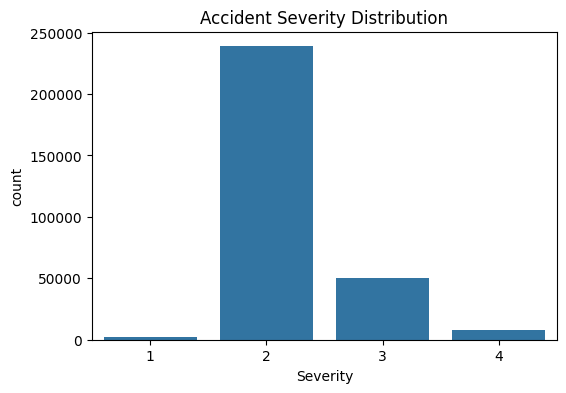

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.countplot(x="Severity", data=df_eda)
plt.title("Accident Severity Distribution")
plt.show()


Accident Duration vs Severity

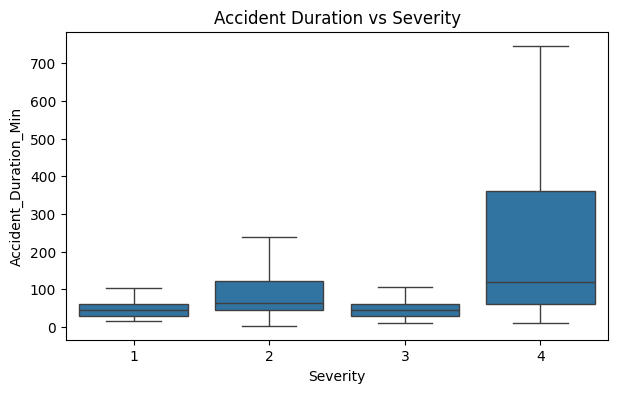

In [25]:
plt.figure(figsize=(7,4))
sns.boxplot(
    x="Severity",
    y="Accident_Duration_Min",
    data=df_eda,
    showfliers=False
)
plt.title("Accident Duration vs Severity")
plt.show()


Severity by Hour of Day

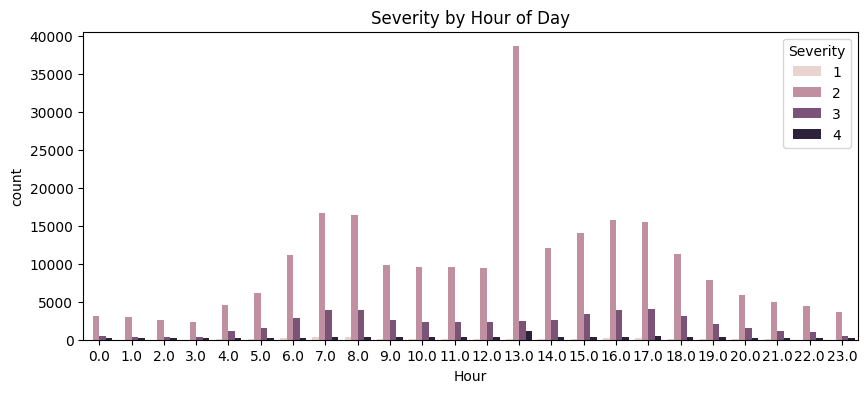

In [26]:
plt.figure(figsize=(10,4))
sns.countplot(
    x="Hour",
    hue="Severity",
    data=df_eda
)
plt.title("Severity by Hour of Day")
plt.show()


Severity by Weather Condition

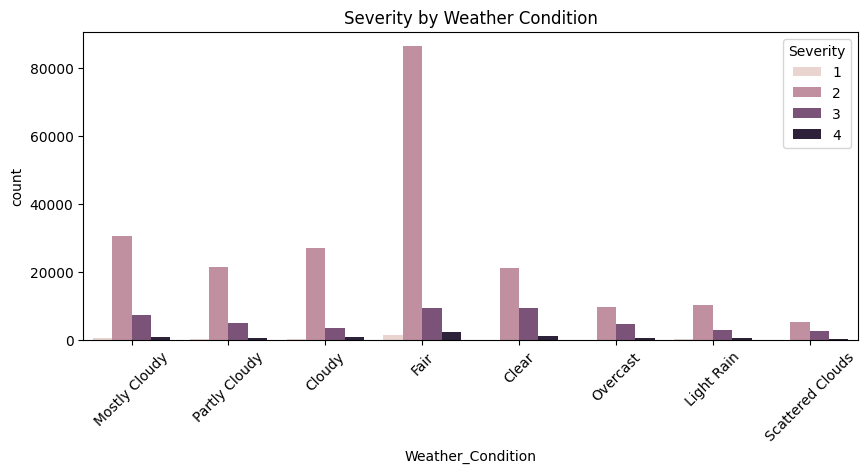

In [27]:
top_weather = df_eda["Weather_Condition"].value_counts().head(8).index

plt.figure(figsize=(10,4))
sns.countplot(
    data=df_eda[df_eda["Weather_Condition"].isin(top_weather)],
    x="Weather_Condition",
    hue="Severity"
)
plt.xticks(rotation=45)
plt.title("Severity by Weather Condition")
plt.show()


In [28]:
X = df.drop(columns=["Severity"])
y = df["Severity"]


Split Data into train-75%, validate-15% & test-10%

In [29]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.25,
    stratify=y,
    random_state=42
)


In [30]:
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.4,  # 40% of 25% = 10%
    stratify=y_temp,
    random_state=42
)


Feature importance

In [73]:
import pandas as pd

feature_importance = pd.Series(
    rf_model.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

feature_importance.head(10)


,0
Distance(mi),0.163841
Accident_Duration_Min,0.121049
Source,0.079921
Wind_Chill(F),0.074683
End_Lng,0.070737
End_Lat,0.066519
Month,0.056902
Start_Lng,0.045378
Start_Lat,0.045112
Traffic_Signal,0.032648


In [31]:
def check_distribution(y, name):
    print(f"\n{name} distribution:")
    print(y.value_counts(normalize=True))

check_distribution(y_train, "Train")
check_distribution(y_val, "Validation")
check_distribution(y_test, "Test")



Train distribution:
Severity
2    0.796670
3    0.168125
4    0.026488
1    0.008717
Name: proportion, dtype: float64

Validation distribution:
Severity
2    0.796670
3    0.168125
4    0.026488
1    0.008717
Name: proportion, dtype: float64

Test distribution:
Severity
2    0.796671
3    0.168125
4    0.026488
1    0.008716
Name: proportion, dtype: float64


Using ordinal encoder


In [32]:
from sklearn.preprocessing import OrdinalEncoder

cat_cols = X_train.select_dtypes(include=["object"]).columns


In [33]:
ordinal_encoder = OrdinalEncoder(
    handle_unknown="use_encoded_value",
    unknown_value=-1
)

X_train[cat_cols] = ordinal_encoder.fit_transform(X_train[cat_cols])
X_val[cat_cols]   = ordinal_encoder.transform(X_val[cat_cols])
X_test[cat_cols]  = ordinal_encoder.transform(X_test[cat_cols])

#LOGISTIC REGRESSION

In [34]:
from sklearn.linear_model import LogisticRegression

baseline_model = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    n_jobs=-1
)

baseline_model.fit(X_train, y_train)


LogisticRegression(class_weight='balanced', max_iter=1000, n_jobs=-1)

In [64]:
y_val_pred1 = baseline_model.predict(X_val)

from sklearn.metrics import classification_report, confusion_matrix

print("Validation Classification Report:")
print(classification_report(y_val, y_val_pred1))


Validation Classification Report:
              precision    recall  f1-score   support

           1       0.03      0.75      0.05     10105
           2       0.92      0.31      0.46    923547
           3       0.30      0.52      0.38    194900
           4       0.07      0.53      0.12     30707

    accuracy                           0.35   1159259
   macro avg       0.33      0.53      0.25   1159259
weighted avg       0.79      0.35      0.44   1159259



In [60]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

y_train_pred1 = baseline_model.predict(X_train)
y_val_pred1   = baseline_model.predict(X_val)
y_test_pred1  = baseline_model.predict(X_test)

train_acc = accuracy_score(y_train, y_train_pred1)
val_acc   = accuracy_score(y_val, y_val_pred1)
test_acc  = accuracy_score(y_test, y_test_pred1)

print(f"Train Accuracy      : {train_acc:.4f}")
print(f"Validation Accuracy : {val_acc:.4f}")
print(f"Test Accuracy       : {test_acc:.4f}")


Train Accuracy      : 0.3532
Validation Accuracy : 0.3534
Test Accuracy       : 0.3534


In [66]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

print("=== LOGISTIC REGRESSION – VALIDATION ===")
print("Accuracy:", accuracy_score(y_val, y_val_pred1))
print("Macro F1:", f1_score(y_val, y_val_pred1, average="macro"))
print(classification_report(y_val, y_val_pred1))

print("\n=== LOGISTIC REGRESSION – TEST ===")
print("Accuracy:", accuracy_score(y_test, y_test_pred1))
print("Macro F1:", f1_score(y_test, y_test_pred1, average="macro"))
print(classification_report(y_test, y_test_pred1))


=== LOGISTIC REGRESSION – VALIDATION ===
Accuracy: 0.3534481940618964
Macro F1: 0.25443025294555566
              precision    recall  f1-score   support

           1       0.03      0.75      0.05     10105
           2       0.92      0.31      0.46    923547
           3       0.30      0.52      0.38    194900
           4       0.07      0.53      0.12     30707

    accuracy                           0.35   1159259
   macro avg       0.33      0.53      0.25   1159259
weighted avg       0.79      0.35      0.44   1159259


=== LOGISTIC REGRESSION – TEST ===
Accuracy: 0.35343149940479274
Macro F1: 0.25427029974980736
              precision    recall  f1-score   support

           1       0.03      0.76      0.05      6736
           2       0.92      0.31      0.46    615699
           3       0.30      0.52      0.38    129934
           4       0.07      0.53      0.12     20471

    accuracy                           0.35    772840
   macro avg       0.33      0.53      0.25

#RANDOM FOREST


In [38]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_leaf=50,
    class_weight="balanced_subsample",
    n_jobs=-1,
    random_state=42
)

rf_model.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced_subsample', max_depth=20,
                       min_samples_leaf=50, n_estimators=200, n_jobs=-1,
                       random_state=42)

In [53]:
y_val_pred = rf_model.predict(X_val)

from sklearn.metrics import classification_report, confusion_matrix

print("Validation Classification Report:")
print(classification_report(y_val, y_val_pred))


Validation Classification Report:
              precision    recall  f1-score   support

           1       0.15      0.91      0.25     10105
           2       0.98      0.64      0.77    923547
           3       0.48      0.84      0.61    194900
           4       0.17      0.84      0.28     30707

    accuracy                           0.68   1159259
   macro avg       0.44      0.81      0.48   1159259
weighted avg       0.87      0.68      0.73   1159259



In [54]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

y_train_pred = rf_model.predict(X_train)
y_val_pred   = rf_model.predict(X_val)
y_test_pred  = rf_model.predict(X_test)

train_acc = accuracy_score(y_train, y_train_pred)
val_acc   = accuracy_score(y_val, y_val_pred)
test_acc  = accuracy_score(y_test, y_test_pred)

print(f"Train Accuracy      : {train_acc:.4f}")
print(f"Validation Accuracy : {val_acc:.4f}")
print(f"Test Accuracy       : {test_acc:.4f}")


Train Accuracy      : 0.6845
Validation Accuracy : 0.6791
Test Accuracy       : 0.6795


In [58]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

print("=== RANDOM FOREST – VALIDATION ===")
print("Accuracy:", accuracy_score(y_val, y_val_pred))
print("Macro F1:", f1_score(y_val, y_val_pred, average="macro"))
print(classification_report(y_val, y_val_pred))

print("\n=== RANDOM FOREST – TEST ===")
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Macro F1:", f1_score(y_test, y_test_pred, average="macro"))
print(classification_report(y_test, y_test_pred))


=== RANDOM FOREST – VALIDATION ===
Accuracy: 0.6790777557042904
Macro F1: 0.47821102938754745
              precision    recall  f1-score   support

           1       0.15      0.91      0.25     10105
           2       0.98      0.64      0.77    923547
           3       0.48      0.84      0.61    194900
           4       0.17      0.84      0.28     30707

    accuracy                           0.68   1159259
   macro avg       0.44      0.81      0.48   1159259
weighted avg       0.87      0.68      0.73   1159259


=== RANDOM FOREST – TEST ===
Accuracy: 0.6794912271621552
Macro F1: 0.4786574755770824
              precision    recall  f1-score   support

           1       0.15      0.92      0.25      6736
           2       0.98      0.64      0.77    615699
           3       0.48      0.84      0.61    129934
           4       0.17      0.84      0.28     20471

    accuracy                           0.68    772840
   macro avg       0.44      0.81      0.48    772840
wei

### Model Comparison

| Model | Validation Accuracy | Validation Macro F1 |
|------|--------------------|---------------------|
| Logistic Regression | 0.35 | 0.25 |
| Random Forest | 0.67 | 0.47 |



#PREDICTION ON UNSEEN DATA

In [67]:
import joblib

joblib.dump(rf_model, "random_forest_severity_model.pkl")
joblib.dump(ordinal_encoder, "categorical_encoder.pkl")


['categorical_encoder.pkl']

In [68]:
new_accident = pd.DataFrame([{
    "Source": "Source2",
    "Start_Lat": 39.9,
    "Start_Lng": -84.0,
    "End_Lat": 39.9,
    "End_Lng": -84.0,
    "Distance(mi)": 0.5,
    "City": "Dayton",
    "County": "Montgomery",
    "State": "OH",
    "Timezone": "US/Eastern",
    "Temperature(F)": 45.0,
    "Wind_Chill(F)": 40.0,
    "Humidity(%)": 70,
    "Pressure(in)": 29.8,
    "Visibility(mi)": 2.0,
    "Wind_Direction": "NW",
    "Wind_Speed(mph)": 10.0,
    "Precipitation(in)": 0.2,
    "Weather_Condition": "Rain",
    "Amenity": 0,
    "Bump": 0,
    "Crossing": 1,
    "Give_Way": 0,
    "Junction": 1,
    "No_Exit": 0,
    "Railway": 0,
    "Roundabout": 0,
    "Station": 0,
    "Stop": 0,
    "Traffic_Calming": 0,
    "Traffic_Signal": 1,
    "Turning_Loop": 0,
    "Sunrise_Sunset": "Night",
    "Civil_Twilight": "Night",
    "Nautical_Twilight": "Night",
    "Astronomical_Twilight": "Night",
    "Accident_Duration_Min": 120,
    "Hour": 22,
    "DayOfWeek": 4,
    "Month": 1
}])


In [70]:
rf_model = joblib.load("random_forest_severity_model.pkl")
ordinal_encoder = joblib.load("categorical_encoder.pkl")


In [71]:
cat_cols = ordinal_encoder.feature_names_in_
new_accident[cat_cols] = ordinal_encoder.transform(new_accident[cat_cols])


In [72]:
severity_pred = rf_model.predict(new_accident)
print("Predicted Accident Severity:", severity_pred[0])

Predicted Accident Severity: 4
